## **[How to Detect Heteroskedasticity in Time Series](https://towardsdatascience.com/how-to-detect-heteroskedasticity-in-time-series-3413a8aa8da9)**
#### **Detecting and dealing with non-constant variance in time series**

A time series is heteroskedastic if its variance changes over time. Otherwise, the data set is homoskedastic.

Heteroskedasticity affects the modeling of time series. So, it is important to detect and deal with this condition.

#### **Introduction**
Let’s start with a visual example.

Figure 1 below shows the popular airline passengers’ time series. You can see that the variation is different across the series. The variance is higher in the latter part of the series. This is also where the level of the data is also higher.



<center> <p>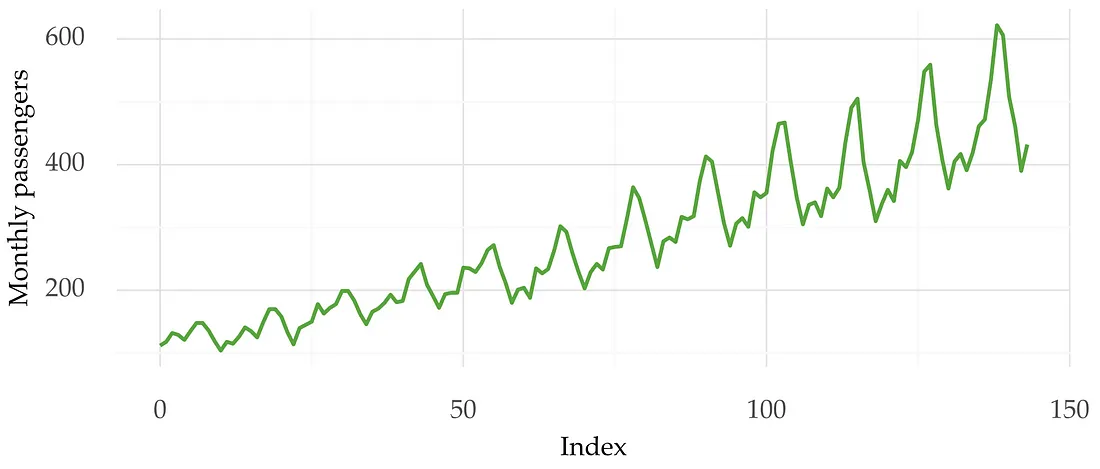</p> </center>

Changes in variance are problematic for forecasting. It impacts the fitting of an adequate model, thereby affecting forecasting performance.

But, visual inspection only is not practical. How can you detect and deal with heteroskedasticity in a more systematic way?

#### **Detecting Heteroskedasticity**

You can check whether a time series is heteroskedastic using statistical tests. These include the following:

- White test;
- Breusch-Pagan test;
- Goldfeld–Quandt test

The main input to these tests is the residuals of a regression model (e.g. ordinary least squares). The null hypothesis is that the residuals are distributed with equal variance. If the p-value is smaller than the significance level we reject this hypothesis. This means that the time series is heteroskedastic. The significance level is often set to a value up to 0.05.

The `statsmodels` Python library has an implementation of the three tests above. Here’s a snippet that wraps these in a single class:

In [15]:
import sys
sys.path.insert(0, '../')

import pandas as pd
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols

TEST_NAMES = ['White', 'Breusch-Pagan', 'Goldfeld-Quandt']
FORMULA = 'value ~ time'


class Heteroskedasticity:

    @staticmethod
    def het_tests(series: pd.Series, test: str) -> float:
        """
        Testing for heteroskedasticity

        :param series: Univariate time series as pd.Series
        :param test: String denoting the test. One of 'white','goldfeldquandt', or 'breuschpagan'

        :return: p-value as a float.

        If the p-value is high, we accept the null hypothesis that the data is homoskedastic
        """
        assert test in TEST_NAMES, 'Unknown test'

        series = series.reset_index(drop=True).reset_index()
        series.columns = ['time', 'value']
        series['time'] += 1

        olsr = ols(FORMULA, series).fit()

        if test == 'White':
            _, p_value, _, _ = sms.het_white(olsr.resid, olsr.model.exog)
        elif test == 'Goldfeld-Quandt':
            _, p_value, _ = sms.het_goldfeldquandt(olsr.resid, olsr.model.exog, alternative='two-sided')
        else:
            _, p_value, _, _ = sms.het_breuschpagan(olsr.resid, olsr.model.exog)

        return p_value

    @classmethod
    def run_all_tests(cls, series: pd.Series):

        test_results = {k: cls.het_tests(series, k) for k in TEST_NAMES}

        return test_results

The class `Heteroskedasticity` contains two functions. The function `het_tests` applies a specific test (White, Breusch-Pagan, or Goldfeld-Quandt). The function `run_all_tests` applies all three tests in one go. The output of these functions is the p-value of the corresponding test.

Here’s how you can apply this code to the time series in Figure 1.

In [16]:
from pmdarima.datasets import load_airpassengers

# https://github.com/vcerqueira/blog/blob/main/src/heteroskedasticity.py
from src.heteroskedasticity import Heteroskedasticity

series = load_airpassengers(True)

test_results = Heteroskedasticity.run_all_tests(series)
test_results
# {'Breusch-Pagan': 4.55e-07,
# 'Goldfeld-Quandt': 8.81e-13,
# 'White': 4.34e-07}

{'White': 4.345754466128658e-07,
 'Breusch-Pagan': 4.559001856883289e-07,
 'Goldfeld-Quandt': 8.81295032926216e-13}

The p-value of all tests is close to zero. So, you can reject the null hypothesis. These tests give compelling evidence for the presence of heteroskedasticity.

Here’s the distribution of the residuals in the first and second half of the time series:

<center> <p>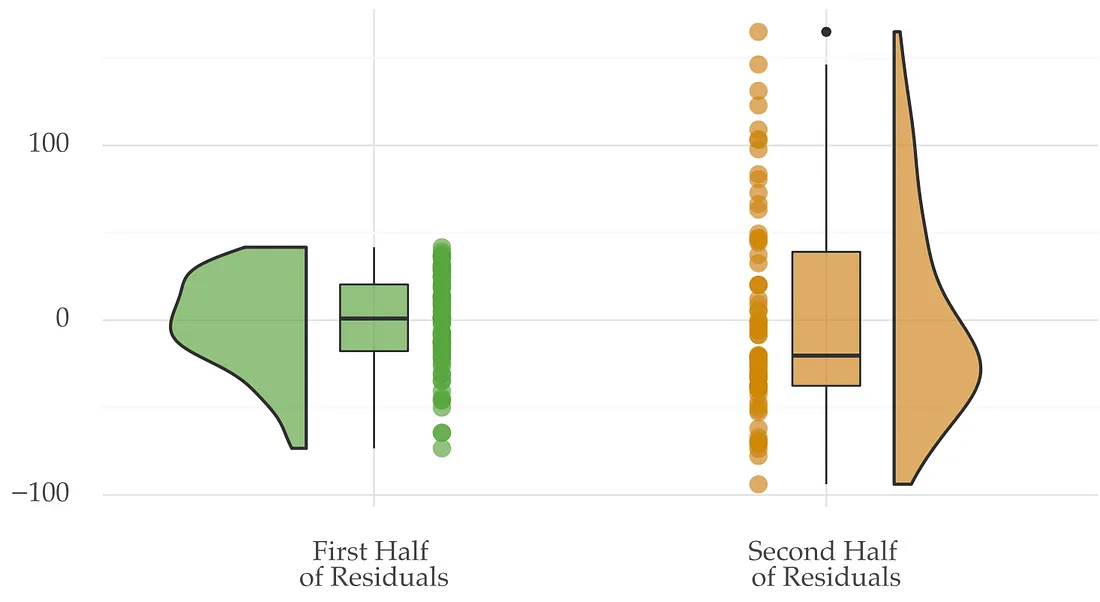</p> </center>

The distribution of residuals is different in these two parts. The Goldfeld-Quandt test uses this type of split to test for heteroskedasticity. It checks if the variance of the residuals is different in two data subsamples.

#### **Transforming the Data**
A common remedy to heteroskedasticity in time series is to transform the data. Taking the logarithm of the time series is helpful to stabilize its variability.

Here’s the same time series as before but log-scaled:

<center> <p>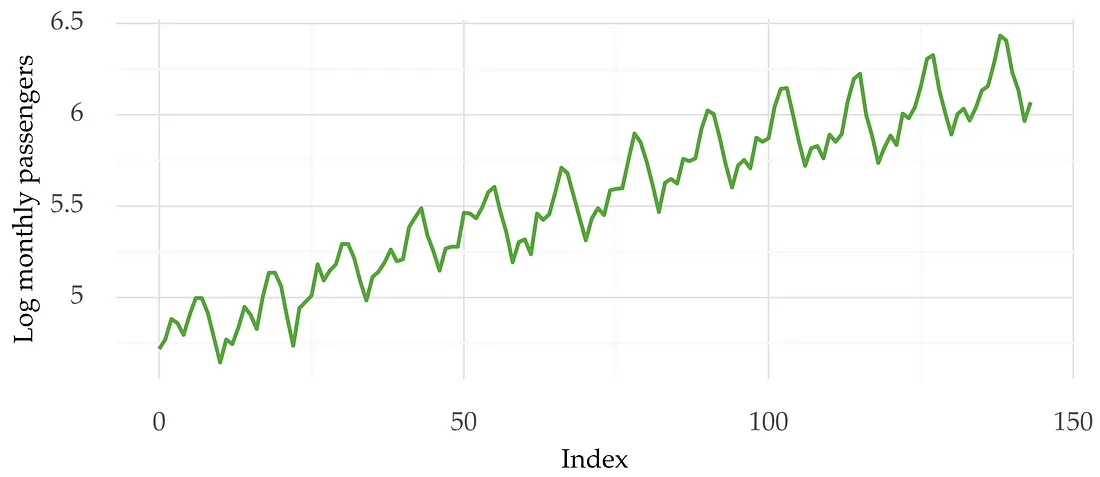</p> </center>

This time, the variability looks steady along the series. Let’s re-run the tests using the log-scaled time series:

In [18]:
import numpy as np

test_results = Heteroskedasticity.run_all_tests(np.log(series))
test_results
# {'Breusch-Pagan': 0.033,
# 'Goldfeld-Quandt': 0.18,
# 'White': 0.10}

{'White': 0.10018100617381405,
 'Breusch-Pagan': 0.03292678759563499,
 'Goldfeld-Quandt': 0.18331567974365628}

The p-values are greater this time. Only one of the tests (Breusch-Pagan) rejects the hypothesis of constant variance. This is assuming a significance level of 0.05.

### **Reverting the log transformation**

Suppose you’re making predictions using log-transformed data. In that case, you need to revert the predictions to the original scale. This is done with the inverse of the transformation — in the case of log, you should use the exponential.

So, the steps of the forecasting process are the following:

1. Transform the data to stabilize the variance;
2. Fit a forecasting model;
3. Get the forecasts, and revert them to the original scale.

Here’s an example.

In [19]:
import numpy as np
from pmdarima.datasets import load_airpassengers
from pmdarima.arima import auto_arima
from sklearn.model_selection import train_test_split

series = load_airpassengers(True)

# leaving the last 12 points for testing
train, test = train_test_split(series, test_size=12, shuffle=False)
# stabilizing the variance in the train
log_train = np.log(train)

# building an arima model, m is the seasonal period (monthly)
mod = auto_arima(log_train, seasonal=True, m=12)

# getting the log forecasts
log_forecasts = mod.predict(12)

# reverting the forecasts
forecasts = np.exp(log_forecasts)

<center> <p>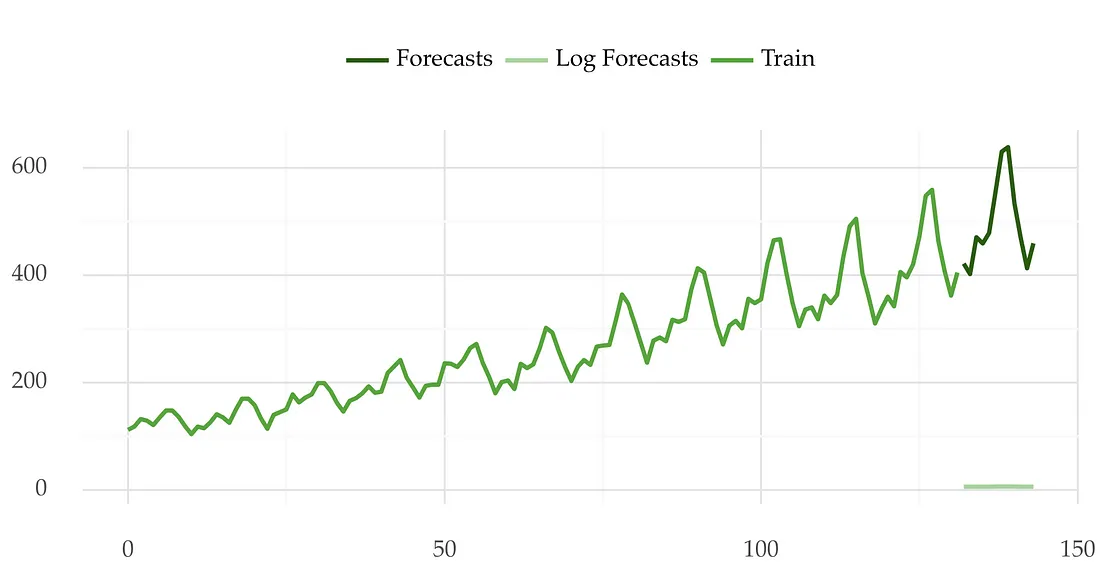</p> </center>

### **Take Aways**
- Time series are heteroskedastic if the variance is not constant;
- You can test if a time series is heteroskedastic using statistical tests. These include the White Breusch-Pagan, or Goldfeld–Quandt tests;
- Use the log transformation to stabilize the variance;
- Don’t forget to revert the forecasts to the original scale.

Thanks for reading and see you in the next story!